In [135]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [149]:
sp500=yf.Ticker("^GSPC")  # ^GSPC is the Ticker for S&P500 index
sp500=sp500.history(period="max")  #gives us the historical data since the beginning of the S&P index
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500.index=(pd.to_datetime(sp500.index))
sp500.index=sp500.index.strftime('%Y-%m-%d')
predictors=[]
target=[]

In [80]:
sp500.head()

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0


<AxesSubplot:xlabel='Date'>

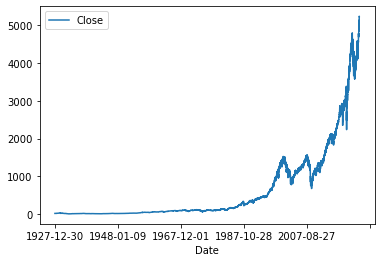

In [32]:
sp500.plot.line(y="Close",use_index=True)

In [150]:
# Seeing if we can predict the following day's closing price of the index
sp500["Tomorrow"]=sp500["Close"].shift(-1) # for each row the new column contains the next day's closing price
sp500["Target"]=(sp500["Tomorrow"]>sp500["Close"]).astype(int)

In [151]:
sp500=sp500.loc["1990-01-01":].copy() # Instead of going too long into historical data we're considering from 1990-01-01

In [106]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2024-03-18,5154.770020,5175.600098,5145.470215,5149.419922,4036220000,5178.509766,1
2024-03-19,5139.089844,5180.310059,5131.589844,5178.509766,4031760000,5224.620117,1
2024-03-20,5181.689941,5226.189941,5171.549805,5224.620117,4064850000,5241.529785,1


In [84]:
sp500.index = pd.to_datetime(sp500.index)
yearly_counts = sp500.groupby(sp500.index.year).size()

print(yearly_counts) # Each year has 250 entries

Date
1990    253
1991    253
1992    254
1993    253
1994    252
1995    252
1996    254
1997    253
1998    252
1999    252
2000    252
2001    248
2002    252
2003    252
2004    252
2005    252
2006    251
2007    251
2008    253
2009    252
2010    252
2011    252
2012    250
2013    252
2014    252
2015    252
2016    252
2017    251
2018    251
2019    252
2020    253
2021    252
2022    251
2023    250
2024     57
dtype: int64


In [163]:
def predict(train,model,test,predictors,target):
    model.fit(train[predictors],train[target])
    predictions=model.predict_proba(test[predictors])[:,1]
    predictions[predictions>=.6]=1
    predictions[predictions<.6]=0
    predictions=pd.Series(predictions,index=test.index)
    precisionscore=precision_score(test["Target"],predictions)
    #plotting
    concatenated_df = pd.concat([test["Target"], predictions], axis=1).tail(100)
    index_values = concatenated_df.index.to_numpy()
    target_values = concatenated_df['Target'].to_numpy()
    prediction_values = concatenated_df[0].to_numpy()  
    plt.plot(index_values, target_values, label='Target')
    plt.plot(index_values, prediction_values, label='Predictions')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
    return precisionscore,concatenated_df
    

<ipython-input-59-e70d1747197c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(train[predictors],train[target])


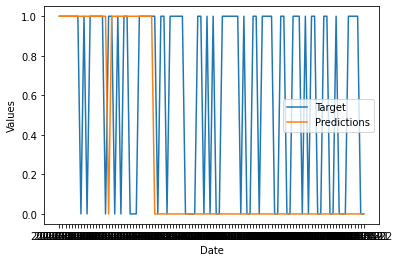

In [60]:
# Random Forest Classifier
train=sp500.iloc[:-550]
test=sp500.iloc[-550:]
predictors=["Open","High","Low","Close","Volume"]
target=["Target"]
precisionscore,concatenated_df=RFCpredict(train,test,predictors,target)
precisionscore

In [153]:
predictors=["Open","High","Low","Close","Volume"]
target=["Target"]
def backtesting(inputt,model,predictors,target,start=2500,step=250): #each year has approx 250 entries so 10 years=2500 entries for training and testing the following 250 entries
    total_predictions=[]
    for i in range(start,inputt.shape[0],step):
        train=inputt.iloc[0:i].copy()
        test=inputt.iloc[i:(i+step)].copy()
        precisionscore,concatenated_df=predict(train,model,test,predictors,target)
        total_predictions.append(concatenated_df)
    return pd.concat(total_predictions)

In [86]:
model=RandomForestClassifier(n_estimators=300,min_samples_split=100,random_state=1)
predictions_=backtesting(sp500,model,predictors,target)
precision_score(predictions_["Target"],predictions_[0])

<ipython-input-67-b6e9b3eed26c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(train[predictors],train[target])
<ipython-input-67-b6e9b3eed26c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(train[predictors],train[target])
<ipython-input-67-b6e9b3eed26c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(train[predictors],train[target])
<ipython-input-67-b6e9b3eed26c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(train[predictors],train[target])
<ipython-input-67-b6e9b3eed26c>:3: DataConversionWarning: A column-v

In [154]:
horizons=[2,5,30,60,180,400]
for i in horizons:
    sp500[f"Close_Ratio_{i}_days"]=sp500["Close"]/sp500.rolling(i).mean()["Close"]
    sp500[f"Trend_{i}_days"]=sp500.shift(1).rolling(i).sum()["Target"]
    predictors+=[f"Close_Ratio_{i}_days",f"Trend_{i}_days"]
sp500=sp500.dropna()

In [164]:
model=RandomForestClassifier(n_estimators=300,min_samples_split=100,random_state=1)
predictions_=backtesting(sp500,model,predictors,target)
precision_score(predictions_["Target"],predictions_[0])

<ipython-input-163-c2c6b3558218>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train[predictors],train[target])
<ipython-input-163-c2c6b3558218>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train[predictors],train[target])
<ipython-input-163-c2c6b3558218>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train[predictors],train[target])
C:\Users\dmsss\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

0.5789473684210527

In [168]:
predictions_["Target"].value_counts()/predictions_.shape[0]

Target
1    0.540435
0    0.459565
Name: count, dtype: float64

In [160]:
model=LogisticRegression(penalty='l2',random_state=None)
predictions_=backtesting(sp500,model,predictors,target)
precision_score(predictions_["Target"],predictions_[0])

C:\Users\dmsss\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dmsss\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dmsss\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dmsss\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

0.5404347826086957

In [159]:
predictors

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Close_Ratio_2_days',
 'Trend_2_days',
 'Close_Ratio_5_days',
 'Trend_5_days',
 'Close_Ratio_30_days',
 'Trend_30_days',
 'Close_Ratio_60_days',
 'Trend_60_days',
 'Close_Ratio_180_days',
 'Trend_180_days',
 'Close_Ratio_400_days',
 'Trend_400_days']